In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint # uniform discrete random variable

In [2]:
# Present working directory
pwd = os.getcwd()
filepath = os.path.join(pwd,"rentals.csv")
filepath

'g:\\Mi unidad\\Colab Notebooks\\House Price Regression\\rentals.csv'

In [3]:
house_df = pd.read_csv(filepath)

EDA

In [4]:
house_df.head()

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,$65.00
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,$65.00


In [5]:
house_df.describe()

,id,latitude,longitude,bathrooms,bedrooms,minimum_nights
count,8.111000e+03,8111.000000,8111.000000,8099.000000,8107.000000,8.111000e+03
mean,2.024561e+07,37.766054,-122.430107,1.395975,1.345874,1.234526e+04
std,1.228565e+07,0.022937,0.026967,0.923213,0.925298,1.110357e+06
min,9.580000e+02,37.704630,-122.513060,0.000000,0.000000,1.000000e+00
25%,8.905668e+06,37.751450,-122.442830,1.000000,1.000000,2.000000e+00
50%,2.161057e+07,37.769150,-122.424650,1.000000,1.000000,4.000000e+00
75%,3.120025e+07,37.785670,-122.410615,1.500000,2.000000,3.000000e+01
max,3.935418e+07,37.828790,-122.368570,14.000000,14.000000,1.000000e+08


In [6]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


<AxesSubplot:>

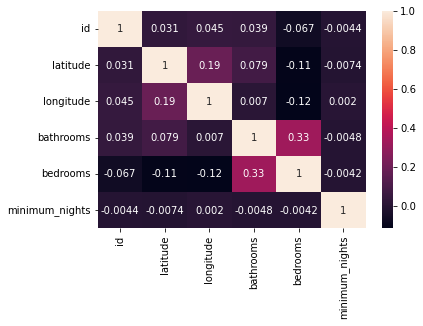

In [7]:
sns.heatmap(house_df.corr(), annot=True)

In [8]:
house_df.isnull().sum()

id                 0
latitude           0
longitude          0
property_type      0
room_type          0
bathrooms         12
bedrooms           4
minimum_nights     0
price              0
dtype: int64

In [9]:
house_df['price'] = house_df['price'].map(lambda x: x.lstrip('$').rstrip(' ').replace(',', '')).astype(float)

### Outliers detection

<AxesSubplot:>

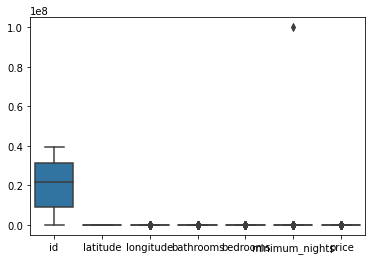

In [10]:
# Let's have a first view of the dataset in order to find out any outlier
sns.boxplot(data=house_df)

Min_nigths seems to have a lot of outliers...

Let's have a look to bathrooms and bedrooms

<AxesSubplot:>

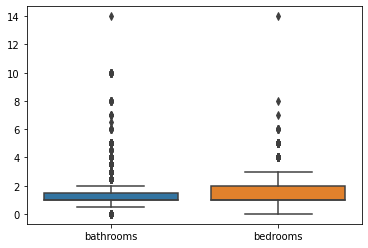

In [11]:
sns.boxplot(data=house_df[['bathrooms','bedrooms']])

In [12]:
# seems normal
house_df[house_df['bathrooms']>10]

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
2386,11442093,37.78199,-122.4217,Boutique hotel,Private room,14.0,14.0,7,69.0


<AxesSubplot:>

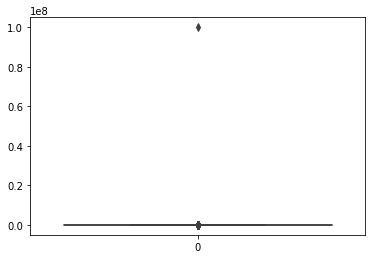

In [13]:
sns.boxplot(data=house_df['minimum_nights'])

In [14]:
house_df[house_df["minimum_nights"]>500]

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
1893,8066789,37.76264,-122.42082,Apartment,Private room,2.0,1.0,1125,3200.0
2912,15344978,37.75071,-122.42521,Apartment,Private room,1.0,1.0,100000000,68.0
3664,19813606,37.79305,-122.42482,Condominium,Entire home/apt,1.0,1.0,1000,150.0


In [15]:
# people to rent out their properties for short stays.
# Removing outliers
cols = ['minimum_nights'] # The columns you want to search for outliers in

# Calculate quantiles and IQR
Q1 = house_df[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = house_df[cols].quantile(0.75)
IQR = Q3 - Q1

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((house_df[cols] < (Q1 - 1.5 * IQR)) | (house_df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter our dataframe based on condition
filtered_df = house_df[condition]

C:\Users\Luis Andres\miniconda3\envs\hands_on_ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='minimum_nights'>

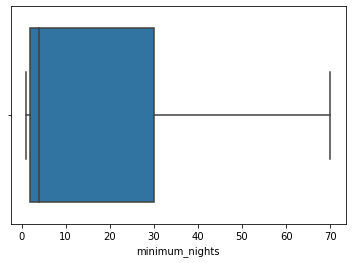

In [16]:
sns.boxplot(filtered_df["minimum_nights"])

{'whiskers': [<matplotlib.lines.Line2D at 0x27dd3862110>,
 'caps': [<matplotlib.lines.Line2D at 0x27dd38626b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x27dd3861e40>],
 'medians': [<matplotlib.lines.Line2D at 0x27dd3862c50>],
 'fliers': [<matplotlib.lines.Line2D at 0x27dd3862f20>],
 'means': []}

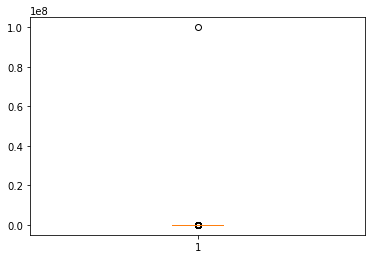

In [17]:
plt.boxplot(house_df["minimum_nights"])

<AxesSubplot:>

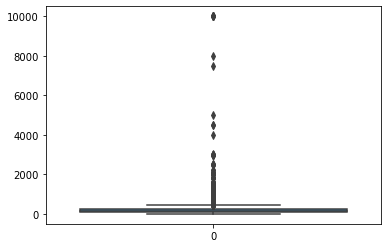

In [18]:
sns.boxplot(data=filtered_df['price'])

In [19]:
# Let's see who ask so much money for its property by night
filtered_df[filtered_df['price']>3000]

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
548,1059961,37.77981,-122.41022,Apartment,Shared room,1.0,1.0,58,5000.0
2818,14887262,37.74255,-122.47917,House,Private room,1.0,1.0,1,8000.0
4280,22567198,37.79955,-122.42823,Apartment,Entire home/apt,1.0,0.0,30,3050.0
4352,22831677,37.75903,-122.39075,Condominium,Entire home/apt,1.5,1.0,30,4500.0
5161,26787002,37.74870,-122.40936,Apartment,Entire home/apt,1.0,1.0,30,4500.0
7345,36185102,37.78898,-122.41659,Boutique hotel,Private room,1.0,1.0,1,10000.0
7346,36185260,37.79240,-122.42060,Boutique hotel,Private room,1.0,1.0,1,10000.0
7347,36185321,37.79404,-122.42202,Boutique hotel,Private room,1.0,1.0,1,10000.0
7348,36185365,37.79196,-122.42184,Boutique hotel,Private room,1.0,1.0,1,10000.0
7349,36185403,37.79396,-122.42200,Boutique hotel,Private room,1.0,1.0,1,10000.0


<AxesSubplot:>

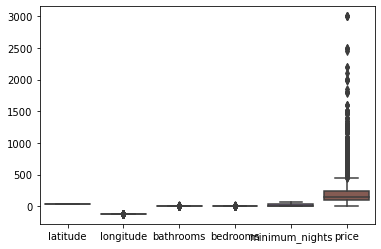

In [20]:
sns.boxplot(data=filtered_df[filtered_df['price']<3000].drop('id',axis=1))

<AxesSubplot:>

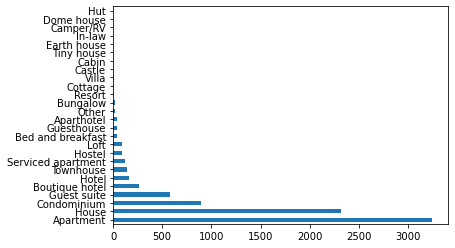

In [21]:
# Class balance
house_df["property_type"].value_counts().plot(kind="barh")

In [22]:
house_df["property_type"].value_counts()

Apartment             3243
House                 2314
Condominium            892
Guest suite            577
Boutique hotel         267
Hotel                  157
Townhouse              142
Serviced apartment     121
Hostel                  92
Loft                    88
Bed and breakfast       43
Guesthouse              41
Aparthotel              41
Other                   24
Bungalow                17
Resort                  14
Cottage                 12
Villa                   10
Castle                   4
Cabin                    3
Tiny house               3
Earth house              2
In-law                   1
Camper/RV                1
Dome house               1
Hut                      1
Name: property_type, dtype: int64

In [23]:
house_df["property_type"].replace(
    to_replace=['Castle','Cabin','Tiny house','Earth house','In-law','Camper/RV','Dome house','Hut'],
    value='Other',
    inplace=True)

doesn't make any sense these prices... we should drop them

## Data Cleaning

In [24]:
house_df.drop('id', axis = 1, inplace = True)
house_df

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,170.0
1,37.75402,-122.45805,House,Private room,1.0,1.0,1,99.0
2,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,235.0
3,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,65.0
4,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,65.0
...,...,...,...,...,...,...,...,...
8106,37.74010,-122.41196,House,Private room,2.0,3.0,30,699.0
8107,37.77799,-122.42159,Condominium,Entire home/apt,1.0,1.0,1,200.0
8108,37.73410,-122.38917,Other,Private room,2.0,1.0,30,69.0
8109,37.78144,-122.41207,Apartment,Entire home/apt,1.0,1.0,30,187.0


In [25]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        8111 non-null   float64
 1   longitude       8111 non-null   float64
 2   property_type   8111 non-null   object 
 3   room_type       8111 non-null   object 
 4   bathrooms       8099 non-null   float64
 5   bedrooms        8107 non-null   float64
 6   minimum_nights  8111 non-null   int64  
 7   price           8111 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 507.1+ KB


## Preprocess data

In [26]:
train_set, test_set = train_test_split(house_df,random_state=42)

In [27]:
target = "price" # "price" is a column that we don't want in our train data

# y
train_labels = train_set[target]
test_labels = test_set[target]

# X 
train = train_set.drop(target, axis = 1)
test = test_set.drop(target, axis = 1)

features = list(train.columns) # or test, doesn't matter, we've got the same cols

In [28]:
train.shape

(6083, 7)

In [29]:
test.shape

(2028, 7)

Pipeline

In [30]:
def preprocess(data):
  house_num = data.select_dtypes(include=[np.number])
  house_cat = data.select_dtypes(include=[object])

  # 1 step: filling NaN
  imputer = SimpleImputer(strategy="median")
  imputed = imputer.fit_transform(house_num)

  # 2 step: scale 
  scaler = StandardScaler()
  house_scaled = scaler.fit_transform(imputed)

  # 3 step: encode categ vars
  cat_encoder = OneHotEncoder(sparse=False)
  housing_cat_1hot = cat_encoder.fit_transform(house_cat) # Creates a "dense array" meaning that all instances have a value not just the ones that are encoded

  # Concatenate
  ml_input_data = np.hstack([housing_cat_1hot, house_scaled])

  return ml_input_data
  

In [31]:
train_data = preprocess(train)
test_data = preprocess(test)

In [32]:
train_data.shape

(6083, 27)

In [33]:
test_data.shape

(2028, 27)

## Select and train a model

### Linear Regression

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(train_data, train_labels) # Fit: How train_data is related to train_labels

LinearRegression()

In [35]:
# Compare against some Test Data

original_values = test_labels

lin_predicted_values = lin_reg.predict(test_data)

comparison_dataframe = pd.DataFrame(data={"Original Values":original_values, "Predicted Values":lin_predicted_values})

comparison_dataframe["Differences"] = comparison_dataframe["Original Values"] - comparison_dataframe["Predicted Values"]

comparison_dataframe["Differences"]

2157   -119.750
453     -18.500
8042    -13.875
5090     32.375
5365   -103.375
         ...   
4231     32.875
7940     79.750
7578    -20.625
4113   -140.375
1600    -21.625
Name: Differences, Length: 2028, dtype: float64

Metrics

In [36]:
lin_mae = mean_absolute_error(original_values, lin_predicted_values)
print("Mean Absolute Error is: {}".format(lin_mae))

Mean Absolute Error is: 117.40717455621302


### Decision Tree Regressor

In [37]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_data, train_labels)

DecisionTreeRegressor(random_state=42)

Metrics

In [38]:
tree_predictions = tree_reg.predict(test_data)

tree_mae = mean_absolute_error(original_values, tree_predictions)
print("Mean Absolute Error is: {}".format(tree_mae))

Mean Absolute Error is: 301.5724852071006


This result it doesn't make sense. There is not error on the DT model. For this reason we have to run a CV.

### Tree Regressor Cross-validation
Instead of just splitting our data into a train and test set and training once, we can do K-Fold Cross-Validation which will split our training dataset into 10 folds (sections) training on 9 of the sections and testing on the last one. It does this for all of the folds which can let us more rigorously evaluate the model.

In [39]:
tree_scores_abs = cross_val_score(tree_reg, train_data, train_labels, scoring = "neg_mean_absolute_error", cv=10)

In [40]:
tree_scores_abs = -tree_scores_abs

In [41]:
tree_scores_abs.std()

17.488554709806735

In [42]:
tree_scores_abs.mean()

111.26646816394434

In [43]:
tree_scores = cross_val_score(tree_reg, train_data, train_labels, scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [44]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [452.44168264 274.72975526 191.2525819  676.55965525 458.83168999
 386.52602554 329.9703311  237.61301328 651.23308646 539.41854051]
Mean: 419.8576361910892
Standard deviation: 158.75523030860293


### Random Forest Regressor
Bunch of Decission Tree regressor. One of after another. True ML model.

In [45]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(train_data, train_labels)

RandomForestRegressor(random_state=42)

Metrics

In [46]:
forest_predictions = forest_reg.predict(test_data)

forest_mae = mean_absolute_error(original_values, forest_predictions)
print("Mean Absolute Error is: {}".format(forest_mae))

Mean Absolute Error is: 257.84066568047336


### Random Forest Cross-validation

In [47]:
forest_scores = cross_val_score(forest_reg, train_data, train_labels, scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [377.79245899 201.54377921 155.74906446 568.23308064 378.41100984
 287.39512643 314.96709008 166.84949286 492.07112323 408.10102297]
Mean: 335.1113248707059
Standard deviation: 130.00459564345715


In [48]:
rf_scores_abs = cross_val_score(forest_reg, train_data, train_labels, scoring = "neg_mean_absolute_error", cv=10)

In [49]:
forest_scores_abs = -rf_scores_abs

In [50]:
forest_scores_abs.std()

17.356555526516903

In [51]:
forest_scores_abs.mean()

93.59363928139314

Let's compare it with Linear Regression score

In [52]:
lin_scores = cross_val_score(lin_reg, train_data, train_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-lin_scores)).describe().astype(int)

count         10
mean      236023
std       745299
min          169
25%          213
50%          262
75%          610
max      2357181
dtype: int32

### Fine-Tuning the Model
After picking a model (in this exercise we decide Random Forest) or set of models that are promising, we'll need to fine-tune the hyperparameters (parameters of the model that aren't affected by training) in order to find the best ones to use for our model. We can use Grid Search in order to accomplish this.

In [53]:
param_grid = [
    # Try 12 (3x4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2x3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(train_data, train_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [54]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 2, 'n_estimators': 3}

In [55]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=2, n_estimators=3,
                      random_state=42)

In [56]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

311.52821970515635 {'max_features': 2, 'n_estimators': 3}
305.21561877370016 {'max_features': 2, 'n_estimators': 10}
298.37734220734944 {'max_features': 2, 'n_estimators': 30}
349.2783615371165 {'max_features': 4, 'n_estimators': 3}
312.1648893684058 {'max_features': 4, 'n_estimators': 10}
292.3017900779892 {'max_features': 4, 'n_estimators': 30}
337.64280241704336 {'max_features': 6, 'n_estimators': 3}
311.0473786407238 {'max_features': 6, 'n_estimators': 10}
297.5220145243967 {'max_features': 6, 'n_estimators': 30}
330.7031760796197 {'max_features': 8, 'n_estimators': 3}
307.3103054212806 {'max_features': 8, 'n_estimators': 10}
298.00539593851744 {'max_features': 8, 'n_estimators': 30}
279.9864227824509 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
295.1630196854396 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
306.5846749810629 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
300.0798593350775 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [57]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.019200,0.001029,0.001801,0.000245,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-92942.414864,-140288.842235,...,-97049.831673,24760.691514,13,-15449.848678,-17750.820112,-40838.007010,-34606.466680,-33913.088761,-28511.646248,10046.566795
1,0.050500,0.001225,0.003999,0.000317,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-73821.110830,-142736.780263,...,-93156.573943,33155.735688,9,-14909.415590,-14262.440222,-21305.215053,-16697.764726,-19417.948486,-17318.556815,2676.941620
2,0.147700,0.001364,0.010300,0.000246,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-53443.350782,-140557.028456,...,-89029.038343,38311.353954,7,-13047.469499,-11844.116927,-11276.238414,-10608.964075,-15765.300458,-12508.417875,1814.681654
3,0.017299,0.000399,0.001501,0.000001,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-129115.608235,-173737.687026,...,-121995.373838,44447.002123,18,-11506.497717,-23059.007855,-38043.883454,-38702.945826,-47202.436523,-31702.954275,12744.064357
4,0.055499,0.000633,0.003600,0.000200,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-76589.181315,-172013.827099,...,-97446.918154,40456.839154,14,-14325.233888,-12360.717896,-19695.067659,-15003.781726,-22328.165804,-16742.593395,3687.374386
5,0.167401,0.001530,0.009799,0.000400,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-71470.989560,-144822.586457,...,-85440.336483,32117.534750,3,-12399.076054,-11324.020498,-11499.417823,-12175.843749,-16027.857715,-12685.243168,1718.927590
6,0.019397,0.000378,0.001601,0.000200,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-73948.672642,-182965.847530,...,-114002.662024,42771.019302,17,-16848.683805,-28959.238846,-45552.605973,-42184.080017,-28523.361573,-32413.594043,10367.535290
7,0.060401,0.000583,0.003600,0.000200,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-63648.085613,-176811.700953,...,-96750.471759,41648.319902,12,-14533.951672,-16373.561385,-23533.192244,-18132.349661,-17912.947510,-18097.200494,3008.417022
8,0.187501,0.002775,0.010099,0.000374,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-65284.831185,-158730.121220,...,-88519.349127,36369.112829,5,-12455.875137,-12072.483922,-14120.657787,-13461.064562,-15099.671948,-13441.950671,1100.620975
9,0.021300,0.000511,0.001600,0.000200,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-71880.380444,-172802.583402,...,-109364.590669,38948.687083,16,-14970.443965,-27088.415354,-51827.896698,-48606.568294,-54094.655686,-39317.595999,15514.450002


### Randomized Search
Randomized search allows to more easily find the hyperparameters that we're interested in because of searching through all possible combinations, it randomly picks a couple and tries those out.

In [58]:
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, 
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', 
                                random_state=42)

rnd_search.fit(train_data, train_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027DD4B4B9A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027DD4B48910>},
                   random_state=42, scoring='neg_mean_squared_error')

In [59]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

298.12982954799253 {'max_features': 7, 'n_estimators': 180}
297.45966221277905 {'max_features': 5, 'n_estimators': 15}
285.3510043883435 {'max_features': 3, 'n_estimators': 72}
288.2217663139475 {'max_features': 5, 'n_estimators': 21}
298.9673136879791 {'max_features': 7, 'n_estimators': 122}
286.9199650329878 {'max_features': 3, 'n_estimators': 75}
288.43844832155787 {'max_features': 3, 'n_estimators': 88}
295.5315810243589 {'max_features': 5, 'n_estimators': 100}
289.99754930401065 {'max_features': 3, 'n_estimators': 150}
333.7562213589375 {'max_features': 5, 'n_estimators': 2}


In [60]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.88209006e-04, 2.45310174e-03, 5.76868225e-04, 4.46334570e-02,
       5.33651647e-05, 2.10026589e-03, 2.63108509e-05, 1.03188010e-03,
       9.99209957e-05, 2.64442849e-04, 1.65609377e-03, 1.05595498e-02,
       5.99872238e-04, 1.41056688e-04, 1.24331656e-03, 9.24792191e-04,
       1.59402570e-03, 7.91775188e-05, 9.41798520e-03, 2.65928953e-04,
       8.66178995e-03, 3.00933994e-03, 3.17934934e-01, 2.74916283e-01,
       8.10794063e-02, 1.03619168e-01, 1.32869458e-01])

### Feature Importance List
Judging the importance of various features is very important as this allows us to explain to our stakeholders which is most important and why which is becomeing more important as more advanced models behave like blackboxes.

In [61]:
feature_importance_list = list(zip(features,feature_importances.tolist()))
feature_importance_list

[('latitude', 0.00018820900614319115),
 ('longitude', 0.002453101735839608),
 ('property_type', 0.0005768682247666645),
 ('room_type', 0.04463345699090273),
 ('bathrooms', 5.336516465462629e-05),
 ('bedrooms', 0.0021002658885990837),
 ('minimum_nights', 2.6310850941108837e-05)]

In [62]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(test_data)


final_mae = mean_absolute_error(test_labels, final_predictions)
print("Mean Absolute Error is: {}".format(final_mae))

Mean Absolute Error is: 236.54454306377383
